In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os

PATH = '/content/gdrive/My Drive/colab/hacaton/remont'

labels = os.listdir(os.path.join(PATH, 'final'))
print(labels)


['komfort', 'standart', 'luks', 'kosmetka', 'bez_otdelki', 'train', 'val']


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

plt.ion()


## Data loaders

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = os.path.join(PATH, 'data')
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        data_transforms[x]
    )
    for x in ['train', 'val']
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=8,
        shuffle=True,
        num_workers=4
    )
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(class_names)


cuda:0
['detskaya', 'garderob', 'gostinnaya', 'prihozhaya', 'spalnya', 'vanna']


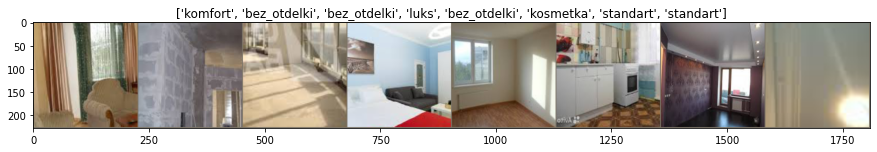

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(15, 7))
imshow(out, title=[class_names[x] for x in classes])
plt.show()


## Train loop

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                print('lr', scheduler.get_last_lr())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            print('SHAPE', inputs.shape)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Fine-tuning

In [ ]:
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
# size of each output sample generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(
    model_ft,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    num_epochs=30
)


Epoch 0/29
----------
lr [0.001]
train Loss: 1.4595 Acc: 0.4047
val Loss: 1.4523 Acc: 0.4007

Epoch 1/29
----------
lr [0.001]
train Loss: 1.3638 Acc: 0.4594
val Loss: 1.4622 Acc: 0.4312

Epoch 2/29
----------
lr [0.001]
train Loss: 1.3450 Acc: 0.4536
val Loss: 1.6176 Acc: 0.3548

Epoch 3/29
----------
lr [0.001]
train Loss: 1.3015 Acc: 0.4809
val Loss: 1.5612 Acc: 0.4075

Epoch 4/29
----------
lr [0.001]
train Loss: 1.2896 Acc: 0.4856
val Loss: 1.5581 Acc: 0.3990

Epoch 5/29
----------
lr [0.001]
train Loss: 1.2598 Acc: 0.4915
val Loss: 1.7271 Acc: 0.3769

Epoch 6/29
----------
lr [0.0001]
train Loss: 1.2576 Acc: 0.5040
val Loss: 1.7138 Acc: 0.4584

Epoch 7/29
----------
lr [0.0001]
train Loss: 1.0819 Acc: 0.5633
val Loss: 1.3712 Acc: 0.5008

Epoch 8/29
----------
lr [0.0001]
train Loss: 1.0388 Acc: 0.5851
val Loss: 1.3831 Acc: 0.4992

Epoch 9/29
----------
lr [0.0001]
train Loss: 1.0331 Acc: 0.5893
val Loss: 1.4141 Acc: 0.4890

Epoch 10/29
----------
lr [0.0001]
train Loss: 1.0243 Ac

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import classification_report

y_test, y_pred = [], []
model_ft.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        y_pred.extend([class_names[j] for j in preds.cpu().numpy()])
        y_test.extend([class_names[j] for j in labels.cpu().numpy()])

print(classification_report(y_test, y_pred))


In [ ]:
torch.save(model_ft.cpu(), os.path.join(PATH, 'models', 'final_ft_cpu.torch'))

## Transfer learning

In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [ ]:
model_conv = train_model(
    model_conv,
    criterion,
    optimizer_conv,
    exp_lr_scheduler,
    num_epochs=25
)


Epoch 0/24
----------
lr [0.001]
train Loss: 1.4866 Acc: 0.4242
val Loss: 1.0611 Acc: 0.6237

Epoch 1/24
----------
lr [0.001]
train Loss: 1.1818 Acc: 0.5683
val Loss: 0.8524 Acc: 0.6808

Epoch 2/24
----------
lr [0.001]
train Loss: 1.0990 Acc: 0.5912
val Loss: 0.7485 Acc: 0.7378

Epoch 3/24
----------
lr [0.001]
train Loss: 1.1307 Acc: 0.5901
val Loss: 0.7539 Acc: 0.7315

Epoch 4/24
----------
lr [0.001]
train Loss: 1.0380 Acc: 0.6225
val Loss: 0.7552 Acc: 0.7400

Epoch 5/24
----------
lr [0.001]
train Loss: 1.0161 Acc: 0.6443
val Loss: 0.6423 Acc: 0.7822

Epoch 6/24
----------
lr [0.0001]
train Loss: 1.0144 Acc: 0.6305
val Loss: 0.7086 Acc: 0.7463

Epoch 7/24
----------
lr [0.0001]
train Loss: 0.9231 Acc: 0.6576
val Loss: 0.6460 Acc: 0.7844

Epoch 8/24
----------
lr [0.0001]
train Loss: 0.9110 Acc: 0.6715
val Loss: 0.6274 Acc: 0.7865

Epoch 9/24
----------
lr [0.0001]
train Loss: 0.8891 Acc: 0.6821
val Loss: 0.6724 Acc: 0.7590

Epoch 10/24
----------


In [ ]:
from sklearn.metrics import classification_report
device = 'cuda'
model_conv.cuda()
model_conv.eval()
y_test, y_pred = [], []
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)

        y_pred.extend([class_names[j] for j in preds.cpu().numpy()])
        y_test.extend([class_names[j] for j in labels.cpu().numpy()])

print(classification_report(y_test, y_pred))


                      precision    recall  f1-score   support

         bez_otdelki       0.91      0.94      0.93        34
                luks       0.74      0.68      0.71        73
            standart       0.58      0.58      0.58        60
trebuetsya_kosmetika       0.70      0.76      0.73        42

            accuracy                           0.71       209
           macro avg       0.73      0.74      0.74       209
        weighted avg       0.71      0.71      0.71       209



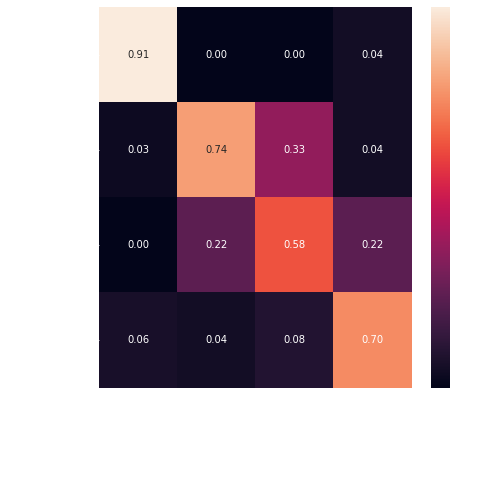

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, columns=class_names, index=class_names)
cm = cm / cm.sum()

with plt.rc_context({'xtick.color':'white', 'ytick.color':'white'}):
    plt.figure(figsize=(7, 7))
    sns.heatmap(cm, annot=True, fmt=".2f")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()


In [ ]:
torch.save(model_conv, os.path.join(PATH, 'models', 'final_tl.torch'))
torch.save(model_conv.cpu(), os.path.join(PATH, 'models', 'final_tl_cpu.torch'))
torch.save(model_conv.state_dict(), os.path.join(PATH, 'models', 'final_tl.trstt'))